<a href="https://colab.research.google.com/github/da-roth/StableAndBiasFreeMonteCarloGreeks/blob/main/src/BFS_Examples/bfs_barrier_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



In [1]:
%%capture
!pip install plotsurfacetool

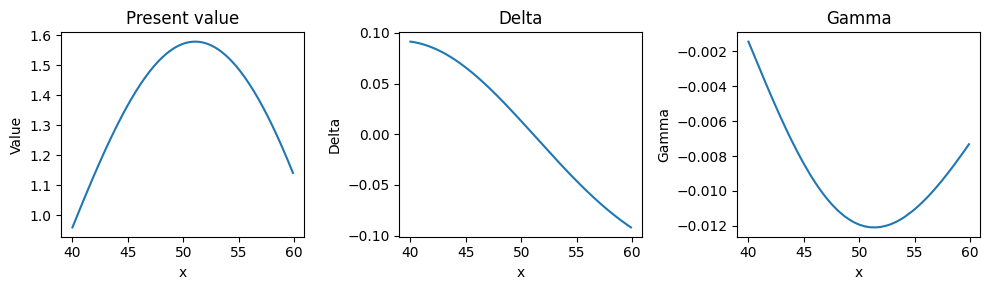

In [2]:
import torch
from scipy.stats import norm

from plotsurfacetool import *


class BarrierPricer:

    @staticmethod
    def bs_Barrier_closed(s_0, t_0, T, r, sigma, K, H, q = 0):
        sigma_t = sigma * np.sqrt(T)
        tau = T - t_0
        # Vanilla price
        d1 = (np.log(s_0/K) + (r-q + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        d2 = (np.log(s_0/K) + (r-q - 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
        c = s_0 * np.exp(-q*tau) * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)
        # up and in price
        gamma = (r - q + 0.5*sigma**2) / sigma**2
        eta = np.log((H**2)/(s_0*K)) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        nu = np.log(s_0/H) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        lmbda = np.log(H/s_0) / (sigma*np.sqrt(tau)) + gamma*sigma*np.sqrt(tau)
        C_ui = s_0*np.exp(-q*tau) * norm.cdf(nu) - K*np.exp(-r*tau) * norm.cdf(nu-sigma*np.sqrt(tau)) \
          - s_0*np.exp(-q*tau) * (H/s_0)**(2*gamma) * (norm.cdf(-eta)-norm.cdf(-lmbda)) \
          + K*np.exp(-r*tau) * (H/s_0)**(2*gamma-2) * (norm.cdf(-eta+sigma*np.sqrt(tau))-norm.cdf(-lmbda+sigma*np.sqrt(tau)))
        # In-out-parity for final price
        if (H > s_0):
          C_uo = c - C_ui
        else:
          C_uo = 0
        return C_uo

    @staticmethod
    def Standard_MC(s_0, t_0, T, r, sigma, K, N, B, m):
        PV, _ = BarrierPricer.Standard_MC_Barrier_torch(s_0, BarrierPricer.path_update_GBM, t_0, T, r, sigma, K, N, B, m)
        return PV

    @staticmethod
    def Standard_MC_torch(s_0, t_0, T, r, sigma, K, N, B, m):
        return BarrierPricer.Standard_MC_Barrier_torch(s_0, BarrierPricer.path_update_GBM, t_0, T, r, sigma, K, N, B, m)

    @staticmethod
    def BFS_MC(s_0, t_0, T, r, sigma, K, N, B, m):
        PV, _ = BarrierPricer.bfc_MC_torch(s_0, BarrierPricer.path_update_GBM, t_0, T, r, sigma, K, N, B, m)
        return PV

    @staticmethod
    def BFS_MC_torch(s_0, t_0, T, r, sigma, K, N, B, m):
        return BarrierPricer.bfc_MC_torch(s_0, BarrierPricer.path_update_GBM, t_0, T, r, sigma, K, N, B, m)

    @staticmethod
    def Standard_MC_Barrier_torch(s_0, path_update_method, t_0, T, r, sigma, K, N, B, m):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        B_torch = torch.tensor(B, device=device, dtype=torch.float64)
        m_torch = torch.tensor(m, device=device)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)

        # Simulartion
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch
        for j in range(int(m)):
            z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
            s_torch = path_update_method(s_torch, dt_torch, z_torch, r_torch, sigma_torch)
            index = (torch.isnan(V) & (s_torch >= B_torch))
            V[index] = 0.0
        #Payoff calculation
        index = torch.isnan(V)
        V[index] = torch.exp(-r_torch * T_torch) * torch.max(s_torch[index] - K_torch, torch.zeros_like(V[index]))
        V = torch.sum(V[index]) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def bfc_MC_torch(s_0, path_update_method, t_0, T, r, sigma, K, N, B, m):
        torch.manual_seed(1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Define variables as PyTorch tensors
        s_0_torch = torch.tensor(s_0, device=device, dtype=torch.float64, requires_grad=True)
        B_torch = torch.tensor(B, device=device, dtype=torch.float64)
        m_torch = torch.tensor(m, device=device)
        T_torch = torch.tensor(T, device=device, dtype=torch.float64)
        r_torch = torch.tensor(r, device=device, dtype=torch.float64)
        sigma_torch = torch.tensor(sigma, device=device, dtype=torch.float64)
        K_torch = torch.tensor(K, device=device, dtype=torch.float64)
        N_torch = torch.tensor(N, device=device)
        two_torch = torch.tensor(2.0, device=device)

        # Simulation
        survival_prob = torch.full((N_torch,), 1.0, dtype=torch.float64, device=device)
        V = torch.full((N_torch,), float('nan'), dtype=torch.float64, device=device)
        s_torch = s_0_torch.expand(N_torch).clone()
        dt_torch = T_torch / m_torch
        for j in range(int(m)):
            z_torch = torch.normal(mean=0, std=1, size=(N_torch,), device=device)
            u_torch = 0.5 * (1 + torch.erf(z_torch / torch.sqrt(torch.tensor(2.0))))
            # force path below barrier
            oss_prob = 0.5 * (torch.erf((torch.log(B_torch / s_torch) - (r_torch - 0.5 * sigma_torch**2) * dt_torch) / (sigma_torch * torch.sqrt(dt_torch)) / torch.sqrt(two_torch)) + 1.0)
            #print(oss_prob.cpu().detach().numpy())
            s_torch_new = s_torch * torch.exp((r_torch- 0.5 * sigma_torch**2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * torch.erfinv(2 * oss_prob * u_torch - 1) * torch.sqrt(two_torch))
            # crossings probs between two steps
            crossing_prob = torch.exp(-2 * torch.max(B_torch-s_torch_new,torch.zeros_like(s_torch)) * torch.max(B_torch-s_torch,torch.zeros_like(s_torch)) / ((sigma_torch*s_torch)**2 * dt_torch))
            survival_prob = survival_prob * (1-crossing_prob) * oss_prob
            s_torch = s_torch_new

        #Payoff calculation
        V = survival_prob * torch.exp(-r_torch * T_torch) * torch.max(s_torch - K_torch, torch.zeros_like(V))
        V = torch.sum(V) / N_torch
        V.backward()
        value = V.item()
        delta = s_0_torch.grad.item()
        return value, delta

    @staticmethod
    def path_update_GBM(s_torch, dt_torch, z_torch, r_torch, sigma_torch):
        return s_torch * torch.exp((r_torch - sigma_torch**2 / 2) * dt_torch + sigma_torch * torch.sqrt(dt_torch) * z_torch)

# Define constants as class attributes
t_0 = 0.0
T = 1.0
r = 0.04
sigma = 0.3
K = 50
N = 40000
B = 70.0
m = 20

closed_solution = lambda s_0: BarrierPricer.bs_Barrier_closed(s_0, t_0, T, r, sigma, K, B)
standard_MC_FD = lambda s_0: BarrierPricer.Standard_MC(s_0, t_0, T, r, sigma, K, N, B, m)
standard_MC_AAD = lambda s_0: BarrierPricer.Standard_MC_torch(s_0, t_0, T, r, sigma, K, N, B, m)
bfs_MC_FD = lambda s_0: BarrierPricer.BFS_MC(s_0, t_0, T, r, sigma, K, N, B, m)
bfs_MC_AAD = lambda s_0: BarrierPricer.BFS_MC_torch(s_0, t_0, T, r, sigma, K, N, B, m)

plotSettings = PlotSettings()
plotSettings.set_S0Array(np.arange(40.0, 60.0, 0.1))
plotSettings.set_FiniteDifferencesStepWidth(0.0001)
plotSettings.set_OutputStatistic(OutputStatistic.Gamma)

# Closed solution
PlotSurfaceTool.Run(closed_solution, plotSettings)

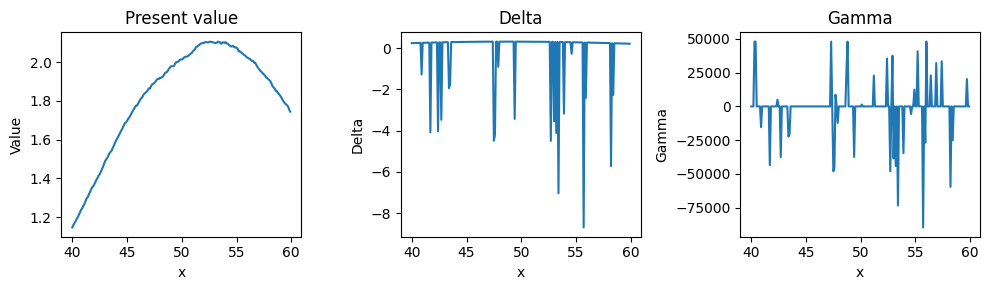

In [3]:
# Standard Monte Carlo using FD
PlotSurfaceTool.Run(standard_MC_FD, plotSettings)

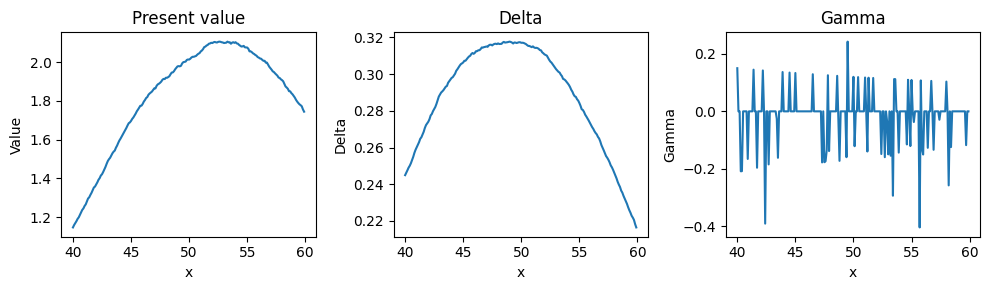

In [4]:
#Standard Monte Carlo using AAD
PlotSurfaceTool.Run(standard_MC_AAD, plotSettings)

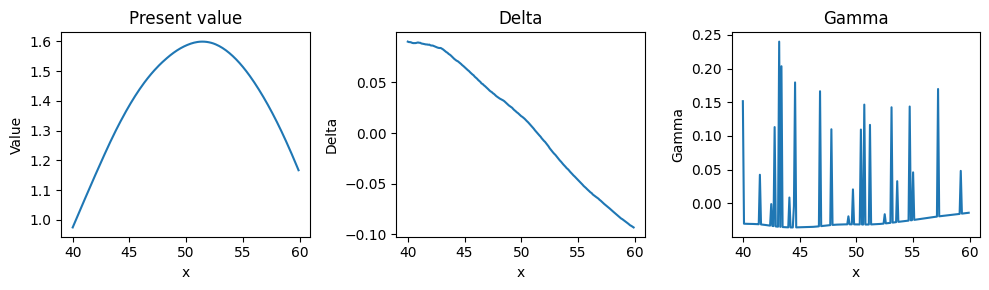

In [5]:
# BFS Monte Carlo estimator using FD
PlotSurfaceTool.Run(bfs_MC_FD, plotSettings)

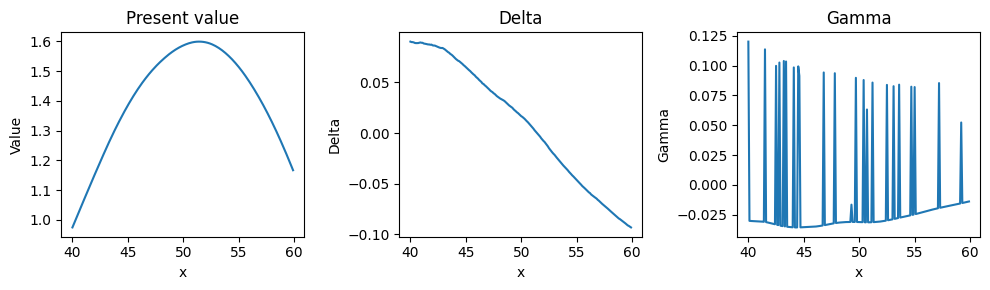

In [6]:
# BFS Monte Carlo estimator using FD
PlotSurfaceTool.Run(bfs_MC_AAD, plotSettings)